<a href="https://colab.research.google.com/github/peimani/Project4/blob/master/Copy_of_Image_Classification_w_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition

In [11]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **Installs and Imports**

In [12]:
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys, glob

import datetime as dt
from sklearn import metrics
from tzlocal import get_localzone

In [73]:
from keras import models
from keras.models import load_model
from keras.preprocessing import image
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator

## Load the Data

In [16]:
# Get the Directory Paths of the Image sets
train_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/chest_xray/chest_xray/train'
val_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/val'
test_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/test'

### Preview the Data

Train set:
PNEUMONIA=3883
NORMAL=1342
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


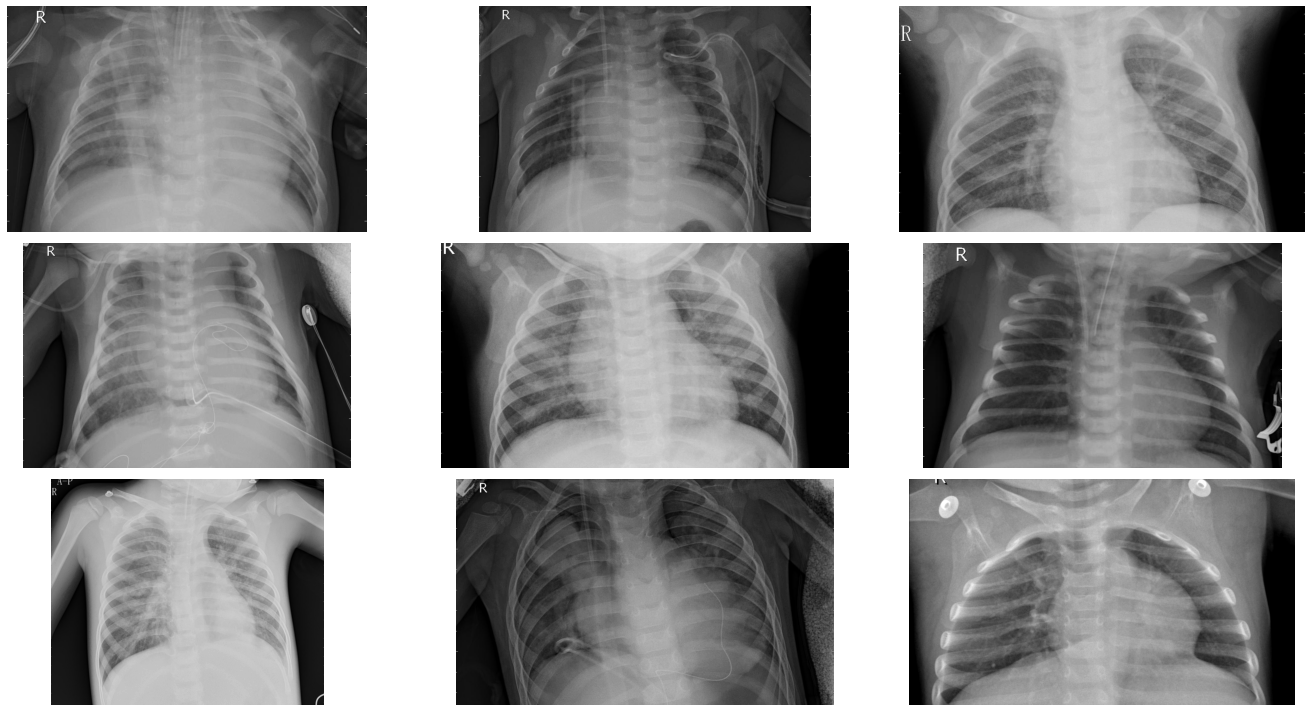

In [17]:

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_img, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_img, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_img, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_img, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_img, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_img, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA")

pneumonia_img = '/content/drive/MyDrive/Colab Notebooks/Data_Files/train/PNEUMONIA'


plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_img, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

## Data Preparation

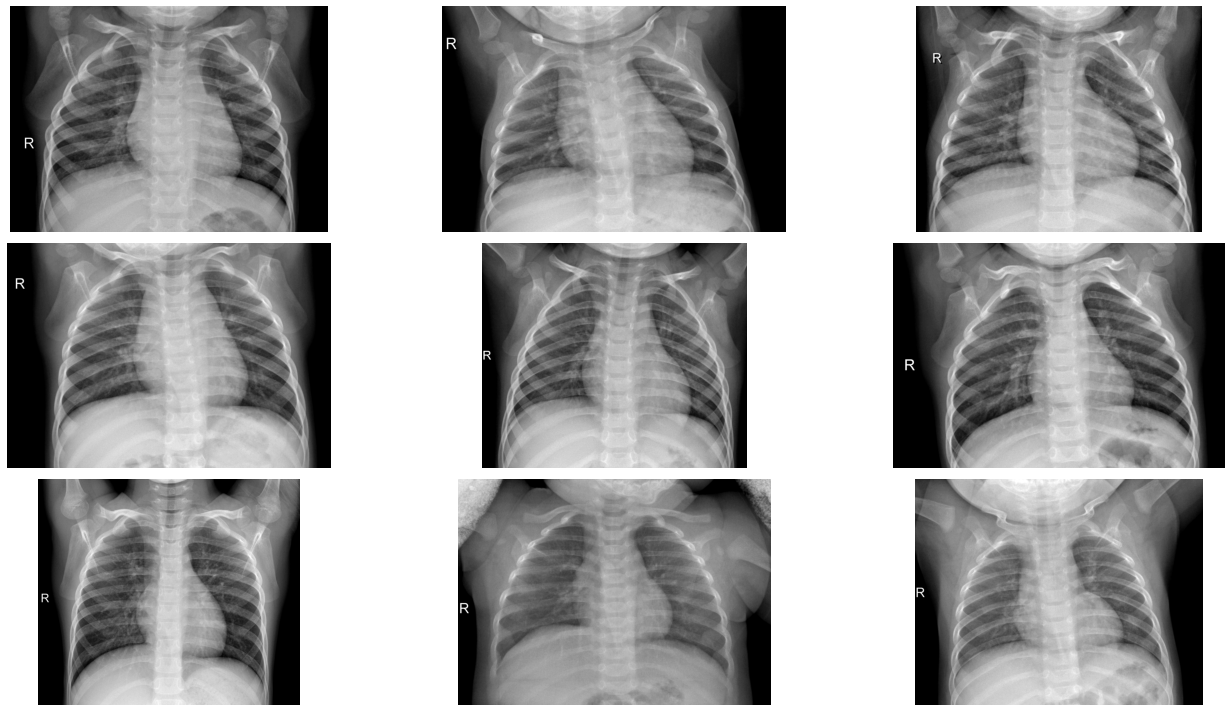

In [18]:
#Preview the images

normal = os.listdir("/content/drive/MyDrive/Colab Notebooks/Data_Files/chest_xray/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/Colab Notebooks/Data_Files/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

### Class Imbalance: 
  There are 1341 'NORMAL' chest x-rays and 3876 x-rays displaying 
  'PNEUMONIA'. To address is class imbalance I will have to generate 2,535 more NORMAL images to equal the 3876 images displaying PNEUMONIA.

### Image Pre-Processing

Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task you'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

In [19]:
# Establish the criteria for data augementation; create random transformation of images
datagen = ImageDataGenerator(
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            rescale = 1./255,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

In [20]:
# Resize all 7685 images in the train directory
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_img,
                                                          target_size = (320, 320), batch_size= 3883)

Found 5223 images belonging to 2 classes.


In [21]:
# Resize all 1 images in the val directory
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_img,
                                                        target_size = (320, 320), batch_size=1)

Found 16 images belonging to 2 classes.


In [22]:
# Resize all 624 images in the val directory
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_img,
                                                          target_size = (320, 320), batch_size=1)

Found 624 images belonging to 2 classes.


In [23]:
# Iterate through all of the images and create image-label datasets stored into "X_images" and "X_labels"
train_images, train_labels = next(train_generator)

In [24]:

val_images, val_labels = next(val_generator)

In [25]:
test_images, test_labels = next(test_generator)

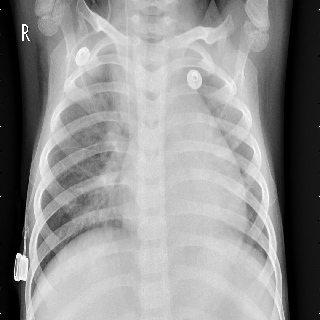

In [26]:
# Preview an image
array_to_img(train_images[5])

## Checking the Shape of Image and Label Arrays

In [27]:
print('Shape of Train Images: ', np.shape(train_images))
print('Shape of Train Labels: ', np.shape(train_labels))
print('Shape of Validation Images: ', np.shape(val_images))
print('Shape of Validation Labels: ', np.shape(val_labels))
print('Shape of Test Images: ', np.shape(test_images))
print('Shape of Test Labels: ', np.shape(test_labels))

Shape of Train Images:  (8, 320, 320, 3)
Shape of Train Labels:  (8, 2)
Shape of Validation Images:  (1, 320, 320, 3)
Shape of Validation Labels:  (1, 2)
Shape of Test Images:  (1, 320, 320, 3)
Shape of Test Labels:  (1, 2)


### Transform Label Matrices

In [28]:
# Transform the labels to (m X 1) matrices
train_labels_final = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
np.shape(train_labels_final)

(8, 1)

In [29]:
val_labels_final = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
np.shape(val_labels_final)

(1, 1)

In [30]:
test_labels_final = np.reshape(test_labels[:,0], (test_labels.shape [0],1))
np.shape(test_labels_final)

(1, 1)

In [31]:
# Verify the Class Labels
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

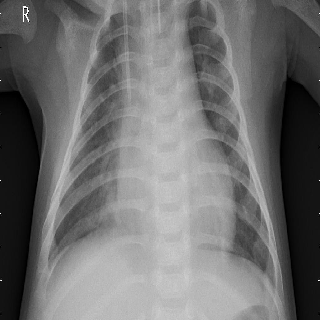

In [32]:

# Select a random image to verify
array_to_img(train_images[4])

In [33]:
# Return the respoctive label and verify that the label matches the image
train_labels_final[4, :]

array([0.], dtype=float32)

In [34]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [35]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                1350020   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [37]:
#model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 318, 318, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 318, 318, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 316, 316, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 316, 316, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 158, 158, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 156, 156, 64)      18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 156, 156, 64)     

In [39]:
# Train the model
results = model.fit(train_generator, 
    epochs=10,
    validation_data=val_generator, 
    class_weight=class_weight,
    steps_per_epoch=10,
    validation_steps=25,)

Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 7.3742 - accuracy: 0.5000 - val_loss: 6.1979 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 2.4025 - accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.8348 - accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.3005 - accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 0.4085 - accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.2636 - accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.2822 - accuracy: 0.5000
Epoch 8/10
10/10 [==============================] - 18s 2s/step - loss: 0.2744 - accuracy: 0.5000
Epoch 9/10
10/10 [==============================] - 16s 2s/step - loss: 0.2808 - accuracy: 0.5000
Epoch 10/10
10/10 [==============================] - 18s 2s/step - loss: 0.3

### Baseline Model Evaluation

In [40]:
evaluation_test = model.evaluate(test_generator)
#print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")


624/624 [==============================] - 157s 252ms/step - loss: 1.3109 - accuracy: 0.5000


In [41]:
evaluation_train = model.evaluate(train_generator) 
#print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

653/653 [==============================] - 1146s 2s/step - loss: 1.2689 - accuracy: 0.5000


In [42]:
evaluation_train

[1.2689214944839478, 0.5]

In [43]:
evaluation_test

[1.3109372854232788, 0.5]

In [44]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Accuracy Evolution')

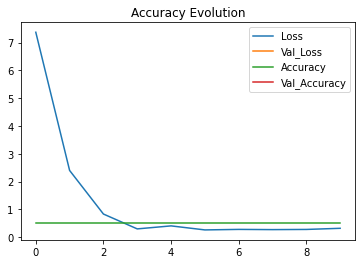

In [45]:
plt.subplot()
plt.plot(results.history['loss'], label='Loss')
plt.plot(results.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot()
plt.plot(results.history['accuracy'], label='Accuracy')
plt.plot(results.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [46]:
#visualize_training_results(results)

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test_generator)

print(confusion_matrix(test_generator.classes, pred > 0.5))
pd.DataFrame(classification_report(test_generator.classes, pred > 0.5, output_dict=True))


[[151  83]
 [269 121]]


,0,1,accuracy,macro avg,weighted avg
precision,0.359524,0.593137,0.435897,0.476331,0.505532
recall,0.645299,0.310256,0.435897,0.477778,0.435897
f1-score,0.461774,0.407407,0.435897,0.434591,0.427795
support,234.000000,390.000000,0.435897,624.000000,624.000000


In [48]:
print(confusion_matrix(test_generator.classes, pred > 0.7))
pd.DataFrame(classification_report(test_generator.classes, pred > 0.7, output_dict=True))

[[216  18]
 [377  13]]


,0,1,accuracy,macro avg,weighted avg
precision,0.364250,0.419355,0.366987,0.391802,0.398690
recall,0.923077,0.033333,0.366987,0.478205,0.366987
f1-score,0.522370,0.061758,0.366987,0.292064,0.234487
support,234.000000,390.000000,0.366987,624.000000,624.000000


In [99]:
pred = pred.predict(val_images)

AttributeError: ignored

### Saving the Baseline Model

In [50]:
import time
import datetime
from datetime import date

model.save('baseline_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [59]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_img,
                                                          target_size = (64, 64), batch_size= 3883, color_mode='grayscale')

Found 5223 images belonging to 2 classes.


In [60]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_img,
                                                target_size = (64, 64), batch_size= 8, color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [62]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_img,
                                                target_size = (64, 64), batch_size= 390, color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [63]:
train_imgs, train_lbls = next(train_gen)


In [65]:
val_imgs, val_lbls = next(val_gen)

In [66]:
test_imgs, test_lbls = next(test_gen)

In [67]:
print('Shape of Train Images: ', np.shape(train_imgs))
print('Shape of Train Labels: ', np.shape(train_lbls))
print('Shape of Validation Images: ', np.shape(val_imgs))
print('Shape of Validation Labels: ', np.shape(val_lbls))
print('Shape of Test Images: ', np.shape(test_imgs))
print('Shape of Test Labels: ', np.shape(test_lbls))

Shape of Train Images:  (3883, 64, 64, 1)
Shape of Train Labels:  (3883, 2)
Shape of Validation Images:  (8, 64, 64, 1)
Shape of Validation Labels:  (8, 2)
Shape of Test Images:  (390, 64, 64, 1)
Shape of Test Labels:  (390, 2)


In [68]:
train_lbls_final = np.reshape(train_lbls[:,0], (3883,1))
np.shape(train_lbls_final)

(3883, 1)

In [70]:
val_lbls_final = np.reshape(val_lbls[:,0], (8,1))
np.shape(val_lbls_final)

(8, 1)

In [71]:
test_lbls_final = np.reshape(test_lbls[:,0], (390,1))
np.shape(test_lbls_final)

(390, 1)

In [74]:
# Optimizer
# Create a dictionary of optimizer, and assign different colors to the optimizers for plotting the model's loss
optimizers = {"RMSprop": {"optimizer": RMSprop(), "color":"blue"},
                  "adam_01": {"optimizer": Adam(lr=0.01), "color":"red"},
                  "sgd": {"optimizer": SGD(), "color":"purple"},
                  "adadelta": {"optimizer": Adadelta(), "color":"pink"},
                  "adagrad": {"optimizer": Adagrad(), "color":"yellow"}}

In [80]:
for optimizer, d in optimizers.items():
    print(f'Testing {optimizer}')

    # Build the CNN

    # Convolution & Pooling
    model2 = Sequential()
     # Test out a tanh activation function
    model2.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
    model2.add(layers.MaxPooling2D((2, 2)))
    
    # Add an L2 Regularization to these layers
    model2.add(layers.Conv2D(32, (4, 4), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model2.add(layers.MaxPooling2D((2,2)))

    # Flattening
    model2.add(layers.Flatten())
    model2.add(layers.Dense(64, activation = 'tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model2.add(layers.Dense(1, activation='softmax'))

    
    model2.compile(optimizer=d['optimizer'],loss='binary_crossentropy', metrics=['accuracy'])

    results2 = model.fit(train_generator, 
    epochs=15,
    validation_data=val_generator, 
    class_weight=class_weight,
    batch_size=100,
    validation_steps=25,)
    
# Add a partition to separate the results
    print('='*125)


Testing RMSprop
Epoch 1/15
653/653 [==============================] - 78s 120ms/step - loss: 0.2646 - accuracy: 0.5000
Epoch 2/15
653/653 [==============================] - 79s 121ms/step - loss: 0.2846 - accuracy: 0.5000
Epoch 3/15
653/653 [==============================] - 80s 122ms/step - loss: 0.2653 - accuracy: 0.5000
Epoch 4/15
653/653 [==============================] - 80s 123ms/step - loss: 0.2646 - accuracy: 0.5000
Epoch 5/15
653/653 [==============================] - 80s 122ms/step - loss: 0.2702 - accuracy: 0.5000
Epoch 6/15
653/653 [==============================] - 80s 122ms/step - loss: 0.2646 - accuracy: 0.5000
Epoch 7/15
653/653 [==============================] - 79s 122ms/step - loss: 0.2646 - accuracy: 0.5000
Epoch 8/15
653/653 [==============================] - 80s 122ms/step - loss: 0.2646 - accuracy: 0.5000
Epoch 9/15
653/653 [==============================] - 80s 123ms/step - loss: 0.2806 - accuracy: 0.5000
Epoch 10/15
653/653 [==============================] - 82

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Accuracy Evolution')

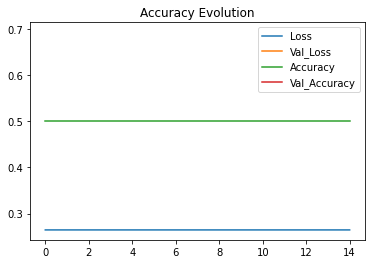

In [81]:
plt.subplot()
plt.plot(results2.history['loss'], label='Loss')
plt.plot(results2.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot()
plt.plot(results2.history['accuracy'], label='Accuracy')
plt.plot(results2.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [85]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

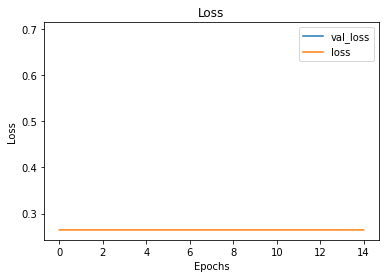

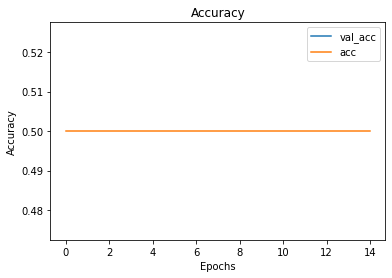

In [86]:
visualize_training_results(results2)

In [93]:
evaluation_test2 = model2.evaluate(train_gen)

InvalidArgumentError: ignored

In [95]:
model2.evaluate(val_gen)

InvalidArgumentError: ignored

In [98]:
preds2 = model2.predict(val_imgs)

InvalidArgumentError: ignored